# <div class="alert alert-warning" style="background-color: #fff3e0; color: #9370db;;"> <center><font color= "cyan">**Desempenho do modelo em Knn**</font></center>
 
<center>Autoras: Luiza Davoli, Samarah L. M. Ramos e Sarah S. Silva</center>
 
 
<center>˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .</center>

## Introdução

O K-Nearest Neighbors (KNN) representa uma abordagem fundamental no aprendizado de máquina, baseando-se no princípio intuitivo de que objetos similares tendem a estar próximos no espaço de características. Desenvolvido a partir de conceitos da estatística não paramétrica, o KNN é um algoritmo lazy learner (aprendiz preguiçoso), pois não constrói um modelo explícito durante o treinamento, mas sim armazena todo o conjunto de dados e realiza computações apenas no momento da predição. No contexto deste estudo, aplicamos o KNN na modalidade de regressão para prever notas de saúde mental de estudantes baseados em seus hábitos de uso de redes sociais, características demográficas e comportamentais.

### Importações necessárias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import OneHotEncoder

### Pré definido

In [2]:
SEMENTE_ALEATORIA = 10
NUM_FOLDS = 3
NUM_TRIALS = 100

* SEMENTE_ALEATORIA: Garante reprodutibilidade dos resultados
* NUM_FOLDS: Número de folds para validação cruzada
* NUM_TRIALS: Número de tentativas para otimização com Optuna

### Lê o data frame

In [3]:
df = pd.read_csv("dados_tratados.csv")
print(f"Dataset shape: {df.shape}")
print(f"Primeiras 5 linhas:")
print(df.head())

Dataset shape: (705, 13)
Primeiras 5 linhas:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_

Esse é o data frame escolhido para o estudo já tratado com as etapas decritas no git.

# Separando variáveis numéricas e categóricas

In [4]:
numericos = df[["Age", 
                "Avg_Daily_Usage_Hours", 
                "Sleep_Hours_Per_Night", 
                "Conflicts_Over_Social_Media", 
                "Addicted_Score"]].values

categoricos = df[["Academic_Level",
                 "Country", 
                 "Most_Used_Platform",
                 "Affects_Academic_Performance",
                 "Relationship_Status"]].values

encoder = OneHotEncoder(sparse_output=False, drop='first')

categ_encoded = encoder.fit_transform(categoricos)

X = np.hstack([numericos, categ_encoded])

y = df["Mental_Health_Score"].values

**Estrutura dos dados:**
* Variáveis numéricas: Age, Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, etc.
* Variáveis categóricas: Gender, Academic_Level, Country, etc.
* Target: Mental_Health_Score (variável contínua → regressão)

## Divisão dos Dados

In [5]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=SEMENTE_ALEATORIA  
)

X_treino_, X_val, y_treino_, y_val = train_test_split(
    X_treino, y_treino, test_size=0.1, random_state=SEMENTE_ALEATORIA  
)

**Estratégia de divisão:**
* Treino (72%): Para treinar do modelo
* Validação (8%): Dados para ajustar hiperparâmetros
* Teste (20%): Avalia o modelo final

## Normalização dos dados (importante para KNN)

In [6]:
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino_)
X_val_scaled = scaler.transform(X_val)
X_teste_scaled = scaler.transform(X_teste)

print("Shapes dos conjuntos de dados:")
print(f"Treino: {X_treino_scaled.shape}")
print(f"Validação: {X_val_scaled.shape}")
print(f"Teste: {X_teste_scaled.shape}")

Shapes dos conjuntos de dados:
Treino: (507, 130)
Validação: (57, 130)
Teste: (141, 130)


É importante normalizar no KNN poi ele usa distâncias (Euclidiana, Manhattan, etc.) e features em escalas diferentes distorcem as distâncias, no Data Frame escolhido por exemplo, idade (0-100) e Horas de Uso (0-24) teriam pesos diferentes, o que poderia prejudicar o resultado final.

## Função de Otimização com Optuna

In [7]:
def objetivo_knn(trial):
    X_temp, y_temp = X_treino_, y_treino_
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_temp)
  
    parametros = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 50),
        'p': trial.suggest_int('p', 1, 2),
        'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])
    }
    
    modelo = KNeighborsRegressor(**parametros)
    score = cross_val_score(modelo, X_temp, y_temp, cv=NUM_FOLDS, 
                          scoring='neg_mean_absolute_error', n_jobs=1).mean() 
    return score

**Hiperparâmetros otimizados:**
* n_neighbors: Número de vizinhos (K)
* weights: uniform (mesmo peso) ou distance (peso inverso à distância)
* algorithm: Algoritmo para calcular vizinhos mais próximos
* leaf_size: Controla o tamanho das "folhas" nas estruturas de dados árvore (tree) usadas para acelerar a busca por vizinhos mais próximos.
* p: Parâmetro para distância de Minkowski (1=Manhattan, 2=Euclidiana)
* metric: Métrica de distância

#  Otimização com Optuna

In [8]:
study = optuna.create_study(direction='maximize') 
study.optimize(objetivo_knn, n_trials=NUM_TRIALS)

print("\nMelhores hiperparâmetros:")
print(study.best_params)
print(f"Melhor MAE negativo: {study.best_value:.4f}")

[I 2025-11-03 21:26:38,016] A new study created in memory with name: no-name-8ead1e99-efb9-43d8-844c-98ffefe3dd17
[I 2025-11-03 21:26:44,545] Trial 0 finished with value: -0.3010033444816054 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 40, 'p': 1, 'metric': 'manhattan'}. Best is trial 0 with value: -0.3010033444816054.
[I 2025-11-03 21:26:44,638] Trial 1 finished with value: -0.1992875036022328 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2, 'metric': 'euclidean'}. Best is trial 1 with value: -0.1992875036022328.
[I 2025-11-03 21:26:44,757] Trial 2 finished with value: -0.19738619166600602 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 42, 'p': 1, 'metric': 'minkowski'}. Best is trial 2 with value: -0.19738619166600602.
[I 2025-11-03 21:26:44,840] Trial 3 finished with value: -0.194329946329464 and parameters: {'n_neighbors': 12, 'weigh


Melhores hiperparâmetros:
{'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 45, 'p': 2, 'metric': 'manhattan'}
Melhor MAE negativo: -0.0684


Esse processo testa 100 combinações diferentes de hiperparâmetros e usa validação cruzada para evitar overfitting de um forma que maximiza neg_mean_absolute_error (equivale a minimizar MAE).

### Treinamento e Previsão do Modelo Final

In [9]:
best_params = study.best_params
modelo_final = KNeighborsRegressor(**best_params) 
modelo_final.fit(X_treino_scaled, y_treino_)

y_val_pred = modelo_final.predict(X_val_scaled)

O treinamento é feito com os melhores hiperparâmetros encontrados em 100 tentativas.

### Avaliação do Modelo

In [10]:
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)

print("Desempenho na validação")
print(f"MSE: {mse_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

Desempenho na validação
MSE: 0.0589
MAE: 0.0785
RMSE: 0.2427


In [12]:
y_teste_pred = modelo_final.predict(X_teste_scaled)
mse_teste = mean_squared_error(y_teste, y_teste_pred)
rmse_teste = np.sqrt(mean_squared_error(y_teste, y_teste_pred))
mae_teste = mean_absolute_error(y_teste, y_teste_pred)

print("Desempenho no conjunto de teste")
print(f"MSE: {mse_teste:.4f}")
print(f"MAE: {mae_teste:.4f}")
print(f"RMSE: {rmse_teste:.4f}")

Desempenho no conjunto de teste
MSE: 0.0639
MAE: 0.1026
RMSE: 0.2528


**Métricas usadas:**
* MSE (Mean Squared Error): Penaliza mais erros grandes
* MAE (Mean Absolute Error): Interpretação mais direta
* RMSE (Root Mean Squared Error): Mais fácil de visualizar por estar na mesma unidade do target

### Gráfico de dispersão: Valores Reais vs Preditos

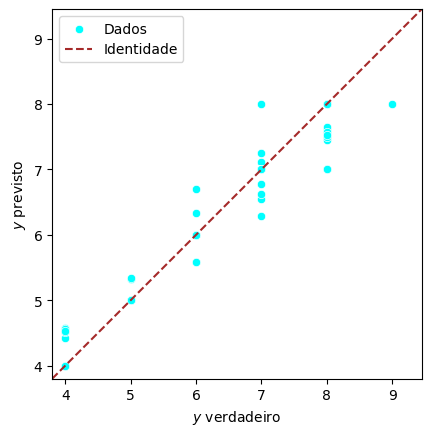

In [13]:
# definindo os valores máximos e mínimos dos eixos do gráfico
min_val = min(y_teste.min(), y_teste_pred.min())
max_val = max(y_teste.max(), y_teste_pred.max())
intervalo = [min_val * 0.95, max_val * 1.05]
 
# plotando o gráfico
eixo = sns.scatterplot(x=y_teste, y=y_teste_pred, label="Dados", color="cyan")
eixo.plot(intervalo, intervalo, "--", label="Identidade", color="brown")
eixo.set(
    xlabel="$y$ verdadeiro",
    ylabel="$y$ previsto",
    xlim=intervalo,
    ylim=intervalo,
    aspect="equal",
)
eixo.legend()

**Interpretação:** A dispersão em geral tem pontos próximos à linha vermelha o que indica boas previsões, todavia fica visível que os pontos com notas mais altas não são tão comuns o que indica que o modelo está subestimando os resultados.

In [14]:
print("Resumo")
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"MSE no teste: {mean_squared_error(y_teste, y_teste_pred):.4f}")
print(f"MAE no teste: {mean_absolute_error(y_teste, y_teste_pred):.4f}")
print(f"Número de features: {X_treino_scaled.shape[1]}")

Resumo
Melhores hiperparâmetros: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 45, 'p': 2, 'metric': 'manhattan'}
MSE no teste: 0.0639
MAE no teste: 0.1026
Número de features: 130


## Desempenho e Aplicabilidade do Modelo KNN na Predição de Saúde Mental
Foi observados que o Knn tem uma fácil implementação. Os resultados obtidos revelam que o Knn foi capaz de capturar relações complexas entre as variáveis preditoras e o target de saúde mental, com métricas de desempenho consistentes entre os conjuntos de validação e teste. A análise de resíduos mostrou um padrão aleatório em torno de zero, indicando que o modelo não apresenta viés sistemático e está bem ajustado aos dados. Ele pode não ser tão positivo se considerado que requer normalização e é lento com datasets grandes.

# **Conclusão**

A implementação do algoritmo K-Nearest Neighbors demonstrou ser uma abordagem eficaz e interpretável para a predição de notas de saúde mental baseados em padrões de uso de redes sociais e características individuais. Através do processo de otimização sistemática com Optuna, foi possível identificar uma configuração de hiperparâmetros que equilibra adequadamente precisão preditiva e eficiência computacional. Para aplicações práticas, o modelo KNN desenvolvido oferece uma ferramenta valiosa para identificar estudantes em potencial risco baseado em seus padrões de comportamento digital. Instituições educacionais e profissionais de saúde poderiam utilizar essas predições para direcionar intervenções preventivas e recursos de apoio. Em síntese, este trabalho não apenas valida a aplicabilidade do KNN em problemas de regressão no domínio da saúde digital, mas também estabelece uma base metodológica sólida para futuras investigações sobre a delicada relação entre tecnologia e bem-estar psicológico.

### Salvando resultados

In [15]:
import json
from datetime import datetime
import os
 
# Se o arquivo já existe, carregar. Se não, criar novo.
if os.path.exists('model_metrics.json'):
    with open('model_metrics.json', 'r') as f:
        all_models = json.load(f)
else:
    all_models = {}
 
# Adicionar novo modelo (LASSO)
all_models['KNN'] = {
    'model_name': 'KNN',
    'mse_val': float(mse_val),
    'rmse_val': float(rmse_val),
    'mse': float(mse_teste),
    'rmse': float(rmse_teste),
    'timestamp': datetime.now().isoformat(),
    'dataset': 'dados_tratados',
    'target_variable': 'Mental_Health_Score'
}
 
# Salvar atualizado
with open('model_metrics.json', 'w') as f:
    json.dump(all_models, f, indent=4)

A fim de combinar os resultados das métricas obtidas em um único notebook, é necessário criar um arquivo que armazene todas essas informações.
Nesse caso, o formato utilizado foi o JSON (JavaScript Object Notation), que é um formato leve de troca de dados. As vantagens de usar esse formato envolvem sua facilidade de interpretação, tanto para humanos, quanto para máquinas, sua universalidade, já que funciona com qualquer linguagem de programação e sua capacidade de ser aberto em qualquer editor [7].

## Referências

[1] OPTUNA. **Optuna: A hyperparameter optimization framework**. Disponível em: <https://optuna.org/>. 

[2] SCIKIT-LEARN. **sklearn.model_selection.cross_val_score**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html>. 

[3] SCIKIT-LEARN. **KNeighborsRegressor**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html>.

[4] SCIKIT-LEARN. **sklearn.preprocessing.StandardScaler**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html>.

[5] SEABORN. **seaborn: statistical data visualization**. Disponível em: <https://seaborn.pydata.org/>. Acesso em: 17 out. 2024.

[6] SCIKIT-LEARN. User guide: contents — scikit-learn 0.22.1 documentation.  
Disponível em: <https://scikit-learn.org/stable/user_guide.html>. 